In [2]:
!pip install -U numpy
print(np.__version__)

NameError: ignored

In [3]:
from google.colab import drive
drive.mount('/content/drive')
import os

import sys

%cd '/content/drive/My Drive/Project-RAS'

!pip install scikit-optimize

os.environ['DDE_BACKEND']='pytorch'




import torch
import numpy as np
print(np.__version__)
import pandas as pd
import time
import matplotlib.pyplot as plt
import deepxde.deepxde as dde
from datasets import makeTesting_dr
from datasets import makeTesting_adv
from datasets import parallel_solver, diffusion_reaction_solver
from utils.func import dirichlet, periodic, H1norm
from utils.PDETriple import PDETripleCartesianProd

date = time.strftime("%Y%m%d-%H-%M-%S", time.localtime())
dde.config.set_random_seed(2023)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Project-RAS
1.25.2


Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [45]:
total_training_vx = 900
ls = 0.05

test_data_size = 100
initial_num = 100

check_num = 2000
select_num = 30#stands for how many chosen every time
solver_worker = 0

lr_start = 5e-3
lr_middle = 5e-3
lr_end = 5e-3

iter_start = 0
iter_middle = 0
iter_end = 60000

batch_start = lambda n: 2
batch_middle = lambda n: n // 5
batch_end = lambda n: n

decay_start = None
decay_middle = None
decay_end = None

# if False:
  # makeTesting_dr(size = test_data_size, length_scale = ls)
# makeTesting_dr(size = 1000,length_scale = ls)

In [46]:
def pde(x, y, aux):
    D = 0.01
    k = 0.01
    dy_t = dde.grad.jacobian(y, x[1], j=1)
    dy_xx = dde.grad.hessian(y, x[1], j=0)
    out = dy_t - D * dy_xx + k * y**2 - aux
    return out

class boundary():
    def __init__(self, loss_coeff = 1, value = 0):
        self.loss_coeff = loss_coeff
        self.value = value

    def __call__(self, targets, outputs):
        return self.loss_coeff * (outputs - self.value).abs().mean()

In [47]:
space = dde.data.GRF(1.0, length_scale = ls, N= 1000, interp="cubic")

geom = dde.geometry.Interval(0, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)
vxs = space.eval_batch(space.random(select_num), np.linspace(0, 1, 101)[:, None])
uxts = parallel_solver(diffusion_reaction_solver, vxs, num_workers = solver_worker)
grid = uxts[0][0].reshape(101 * 101, -1)
uxts = np.asarray([u for grid, u in uxts]).reshape(-1, 101 * 101)


train_vxs = vxs
train_grid = grid
train_uxts = uxts
print(train_vxs.shape, train_grid.shape, train_uxts.shape)

test_data = np.load(f"datasets/DF_1000_{ls:.2f}_101_101.npz")
test_vxs = test_data["vxs"]
test_grid = test_data["xt"].reshape(-1, 2)
test_uxts = test_data["uxts"].reshape(-1, 101 * 101)
del test_data
print(test_vxs, test_grid.shape, test_uxts.shape)


(30, 101) (10201, 2) (30, 10201)
[[ 1.3850499   1.5440884   1.755796   ... -1.445284   -1.7669727
  -1.9704516 ]
 [-0.41721055 -0.32364768 -0.20068924 ...  0.18714754  0.16174012
   0.04998445]
 [ 0.5368845   0.5450927   0.5913005  ...  0.4676569   0.18906356
  -0.06553803]
 ...
 [ 1.641742    1.7161953   1.7562327  ... -0.8426143  -0.76150274
  -0.60615855]
 [ 2.2287402   2.1736064   1.9902866  ...  1.8888345   1.957745
   1.8897184 ]
 [-0.836535   -1.1495248  -1.3660958  ...  0.07686353  0.09866629
   0.17099588]] (10201, 2) (1000, 10201)


In [48]:
init_indices = (grid[:, 1] == 0).nonzero()[0]
bound_indices = np.logical_or(grid[:, 0] == 0, grid[:, 0] == 1).nonzero()[0]
boundary_losses = []
boundary_losses.append((init_indices, boundary()))
boundary_losses.append((bound_indices, boundary()))
print(init_indices.shape, bound_indices.shape)

(101,) (202,)


In [49]:
data = PDETripleCartesianProd(X_train=(train_vxs, train_grid), y_train=train_uxts, X_test=(test_vxs, test_grid), y_test=test_uxts, boundary = [])

# Net
net = dde.nn.DeepONetCartesianProd(
    [101, 100, 100],
    [2, 100, 100, 100],
    "gelu",
    "Glorot normal",
)

# net.apply_feature_transform(periodic)
net.apply_output_transform(dirichlet)

model = dde.Model(data, net)
model.compile("adam",
              lr= lr_start,
              loss= ["mse"],
              metrics = ["mean l2 relative error"],
              decay = decay_start)


Compiling model...
'compile' took 0.000471 s



Training model...

0         [1.63e-01]    [1.25e-01]    [1.04e+00]    

Best model at step 0:
  train loss: 1.63e-01
  test loss: 1.25e-01
  test metric: [1.04e+00]

'train' took 0.105223 s



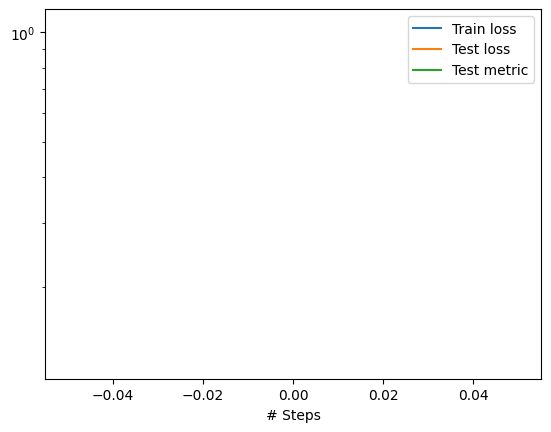

In [50]:
losshistory, train_state = model.train(iterations = iter_start, batch_size = batch_start(len(train_vxs)))
dde.utils.plot_loss_history(losshistory)

In [51]:
losshistory.to_pandas().to_csv(f"results/loss_history_{date}_h1.csv", index=False)

195.45905621235386 35.23366698560792
60
Compiling model...
'compile' took 0.000623 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.43e-01]    [1.25e-01]    [1.04e+00]    

Best model at step 0:
  train loss: 1.43e-01
  test loss: 1.25e-01
  test metric: [1.04e+00]

'train' took 0.101025 s



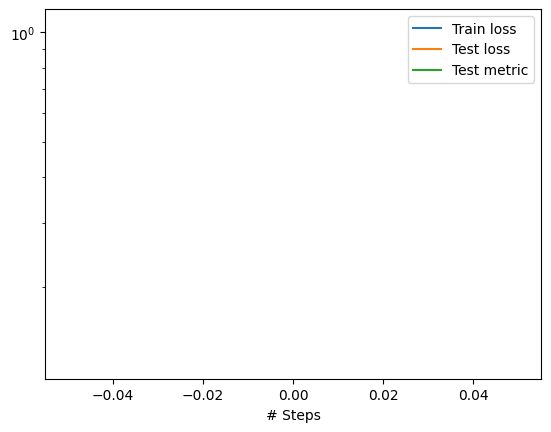

196.43595397369884 35.47455436633154
90
Compiling model...
'compile' took 0.001097 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.22e-01]    [1.25e-01]    [1.04e+00]    

Best model at step 0:
  train loss: 1.22e-01
  test loss: 1.25e-01
  test metric: [1.04e+00]

'train' took 0.164182 s



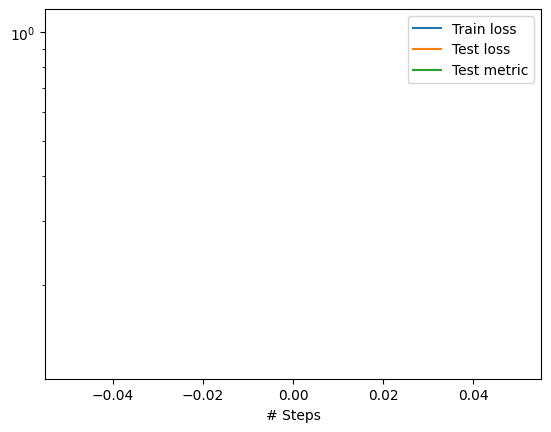

196.9336914533573 35.53902156246931
120
Compiling model...
'compile' took 0.000324 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.37e-01]    [1.25e-01]    [1.04e+00]    

Best model at step 0:
  train loss: 1.37e-01
  test loss: 1.25e-01
  test metric: [1.04e+00]

'train' took 0.077023 s



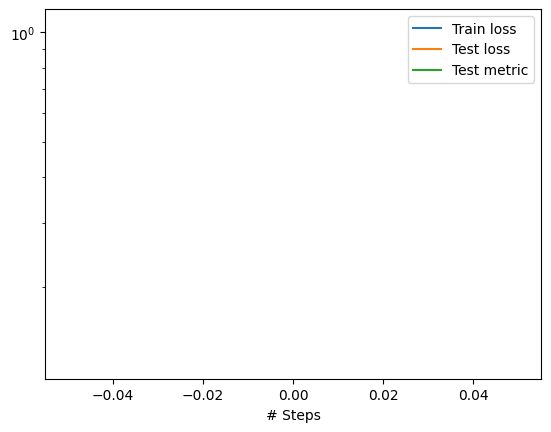

197.04634215414524 34.78904751843737
150
Compiling model...
'compile' took 0.000304 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.40e-01]    [1.25e-01]    [1.04e+00]    

Best model at step 0:
  train loss: 1.40e-01
  test loss: 1.25e-01
  test metric: [1.04e+00]

'train' took 0.082426 s



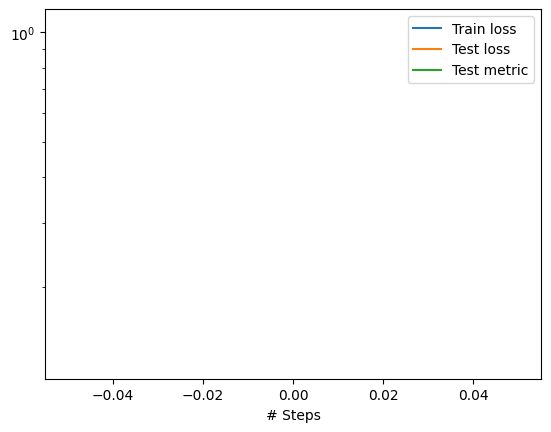

195.8551621390205 34.75575029801568
180
Compiling model...
'compile' took 0.001520 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.58e-01]    [1.25e-01]    [1.04e+00]    

Best model at step 0:
  train loss: 1.58e-01
  test loss: 1.25e-01
  test metric: [1.04e+00]

'train' took 0.122647 s



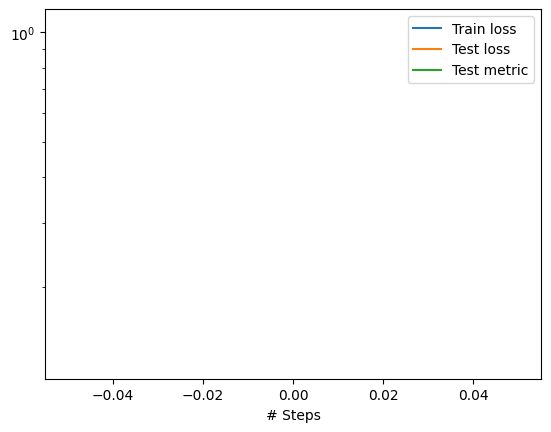

195.53247565876242 34.31538932125402
210
Compiling model...
'compile' took 0.000639 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.41e-01]    [1.25e-01]    [1.04e+00]    

Best model at step 0:
  train loss: 1.41e-01
  test loss: 1.25e-01
  test metric: [1.04e+00]

'train' took 0.111416 s



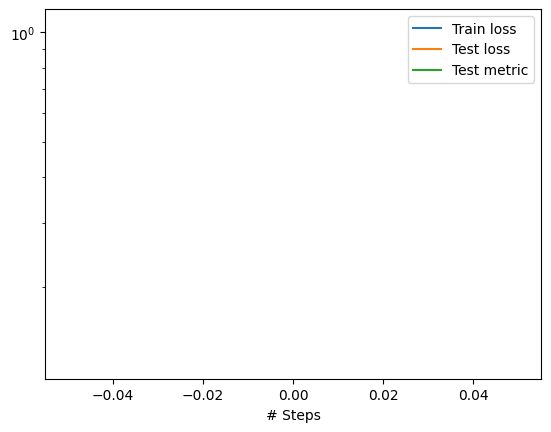

195.3426140761504 35.18096606614166
240
Compiling model...
'compile' took 0.000624 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.57e-01]    [1.25e-01]    [1.04e+00]    

Best model at step 0:
  train loss: 1.57e-01
  test loss: 1.25e-01
  test metric: [1.04e+00]

'train' took 0.088029 s



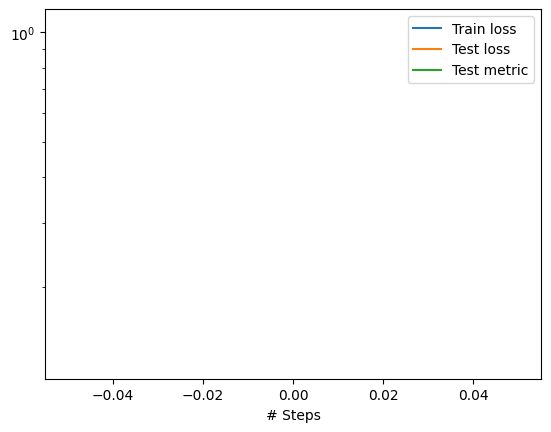

195.65403177404414 35.152191492900656
270
Compiling model...
'compile' took 0.000332 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.44e-01]    [1.25e-01]    [1.04e+00]    

Best model at step 0:
  train loss: 1.44e-01
  test loss: 1.25e-01
  test metric: [1.04e+00]

'train' took 0.154105 s



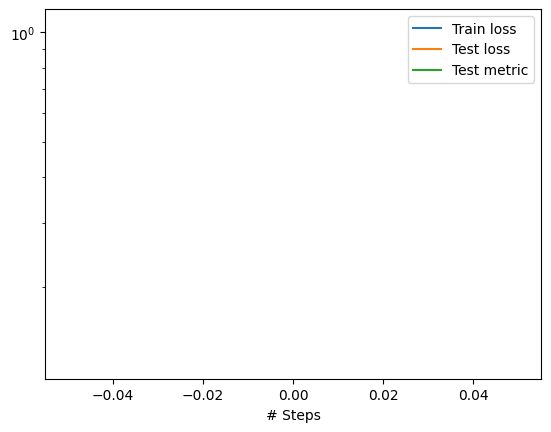

195.98604465264282 35.43331152453152
300
Compiling model...
'compile' took 0.000338 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.49e-01]    [1.25e-01]    [1.04e+00]    

Best model at step 0:
  train loss: 1.49e-01
  test loss: 1.25e-01
  test metric: [1.04e+00]

'train' took 0.104091 s



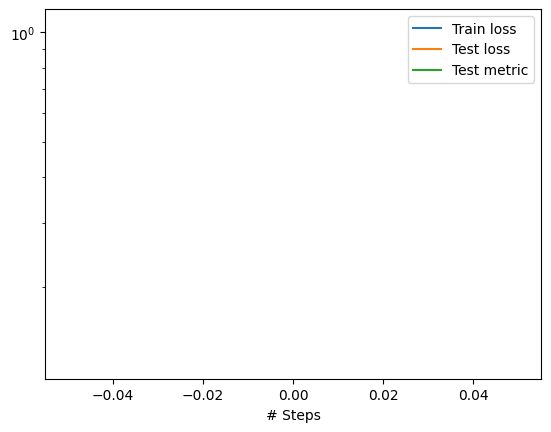

196.77650298903828 34.251515889773756
330
Compiling model...
'compile' took 0.000288 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.63e-01]    [1.25e-01]    [1.04e+00]    

Best model at step 0:
  train loss: 1.63e-01
  test loss: 1.25e-01
  test metric: [1.04e+00]

'train' took 0.078914 s



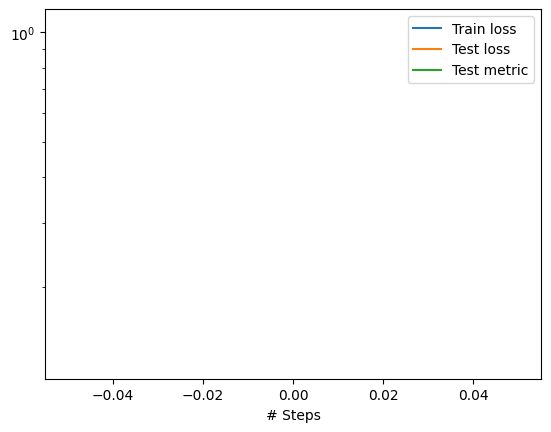

195.86949342072134 34.511585056704845
360
Compiling model...
'compile' took 0.000303 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.57e-01]    [1.25e-01]    [1.04e+00]    

Best model at step 0:
  train loss: 1.57e-01
  test loss: 1.25e-01
  test metric: [1.04e+00]

'train' took 0.146021 s



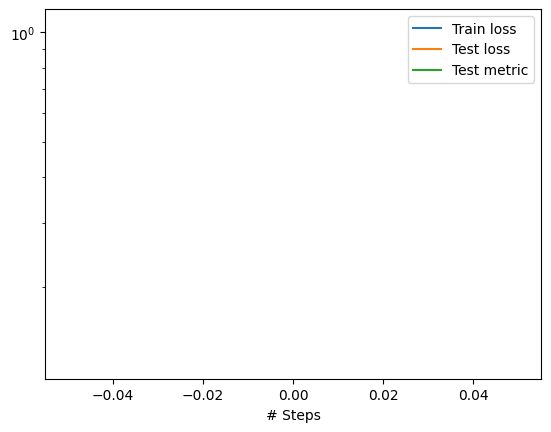

197.0138808012447 34.168436576584064
390
Compiling model...
'compile' took 0.000233 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.37e-01]    [1.25e-01]    [1.04e+00]    

Best model at step 0:
  train loss: 1.37e-01
  test loss: 1.25e-01
  test metric: [1.04e+00]

'train' took 0.102983 s



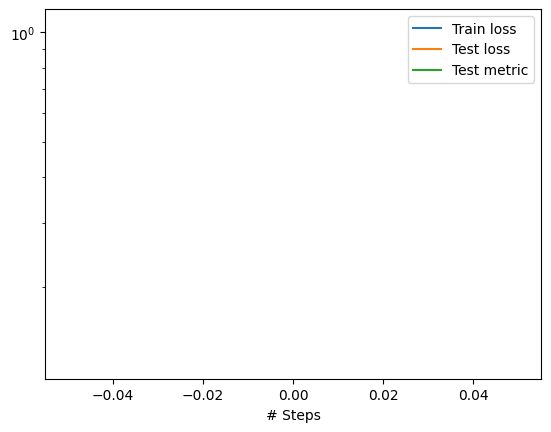

196.516382569649 35.002646607431565
420
Compiling model...
'compile' took 0.000325 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.47e-01]    [1.25e-01]    [1.04e+00]    

Best model at step 0:
  train loss: 1.47e-01
  test loss: 1.25e-01
  test metric: [1.04e+00]

'train' took 0.134324 s



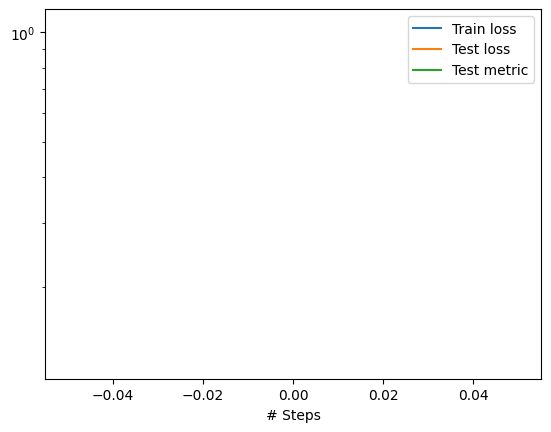

195.36129364613205 35.915961972456486
450
Compiling model...
'compile' took 0.000646 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.47e-01]    [1.25e-01]    [1.04e+00]    

Best model at step 0:
  train loss: 1.47e-01
  test loss: 1.25e-01
  test metric: [1.04e+00]

'train' took 0.091173 s



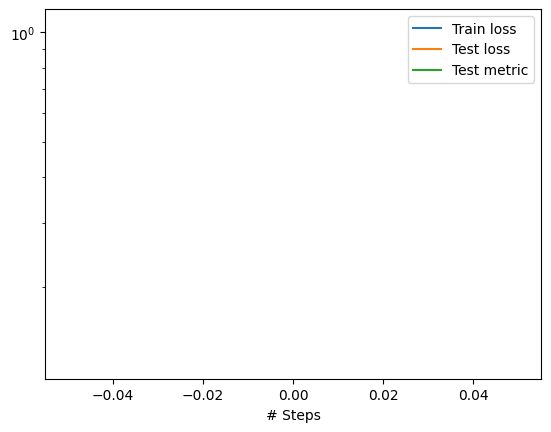

195.41446701175917 33.72698084962901
480
Compiling model...
'compile' took 0.000623 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.63e-01]    [1.25e-01]    [1.04e+00]    

Best model at step 0:
  train loss: 1.63e-01
  test loss: 1.25e-01
  test metric: [1.04e+00]

'train' took 0.084447 s



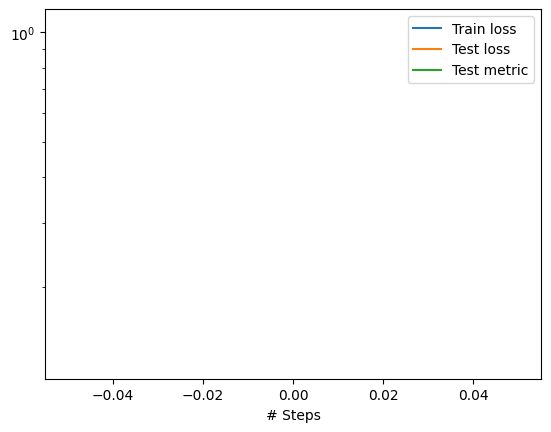

196.62256833658589 34.97720037070242
510
Compiling model...
'compile' took 0.000333 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.54e-01]    [1.25e-01]    [1.04e+00]    

Best model at step 0:
  train loss: 1.54e-01
  test loss: 1.25e-01
  test metric: [1.04e+00]

'train' took 0.108679 s



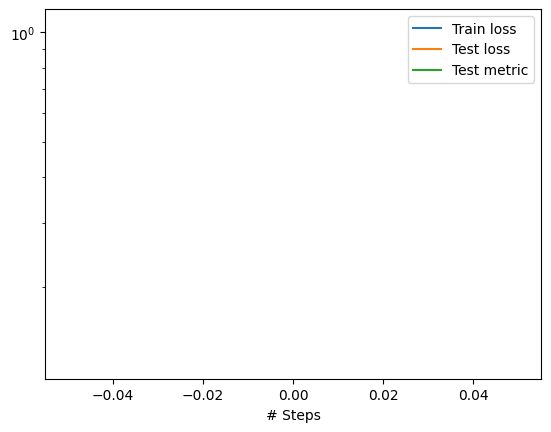

195.1750435374044 35.03424941085898
540
Compiling model...
'compile' took 0.000323 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.42e-01]    [1.25e-01]    [1.04e+00]    

Best model at step 0:
  train loss: 1.42e-01
  test loss: 1.25e-01
  test metric: [1.04e+00]

'train' took 0.120421 s



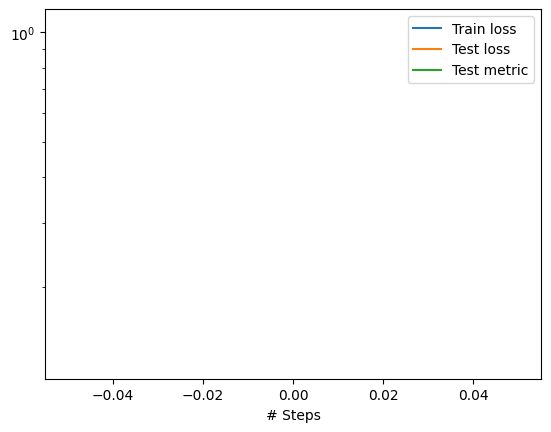

196.390412411257 35.21005034822978
570
Compiling model...
'compile' took 0.000596 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.42e-01]    [1.25e-01]    [1.04e+00]    

Best model at step 0:
  train loss: 1.42e-01
  test loss: 1.25e-01
  test metric: [1.04e+00]

'train' took 0.081823 s



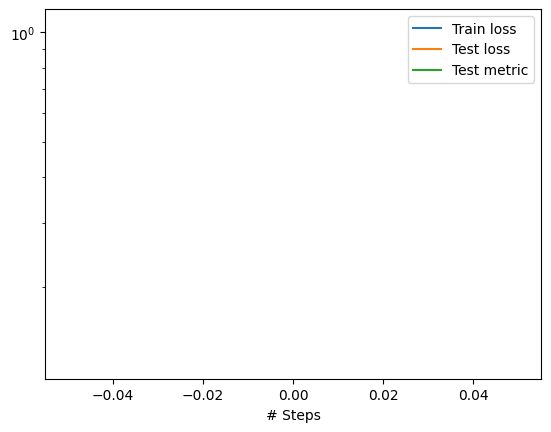

195.4842258999146 34.913981739111726
600
Compiling model...
'compile' took 0.000910 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.60e-01]    [1.25e-01]    [1.04e+00]    

Best model at step 0:
  train loss: 1.60e-01
  test loss: 1.25e-01
  test metric: [1.04e+00]

'train' took 0.115822 s



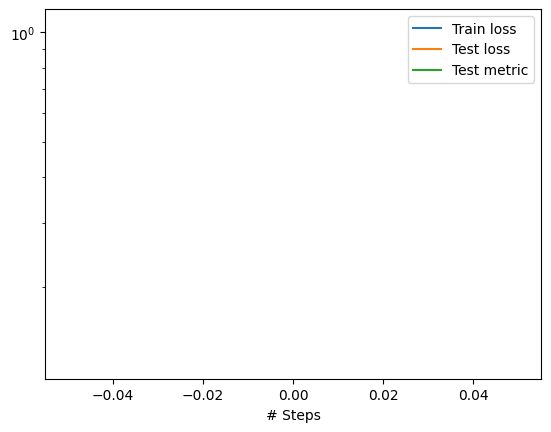

196.13735321621363 35.575924793667895
630
Compiling model...
'compile' took 0.000713 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.54e-01]    [1.25e-01]    [1.04e+00]    

Best model at step 0:
  train loss: 1.54e-01
  test loss: 1.25e-01
  test metric: [1.04e+00]

'train' took 0.113185 s



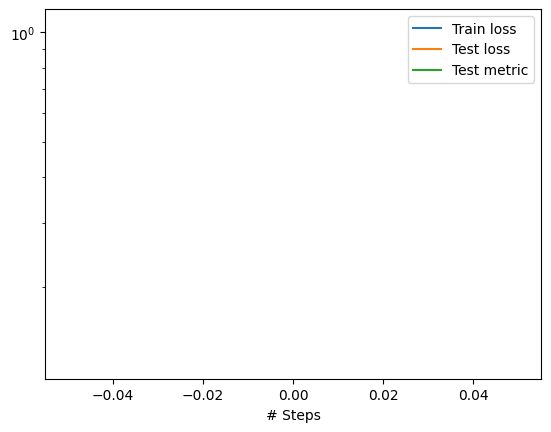

195.91485343260277 34.52703637725035
660
Compiling model...
'compile' took 0.000883 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.65e-01]    [1.25e-01]    [1.04e+00]    

Best model at step 0:
  train loss: 1.65e-01
  test loss: 1.25e-01
  test metric: [1.04e+00]

'train' took 0.112958 s



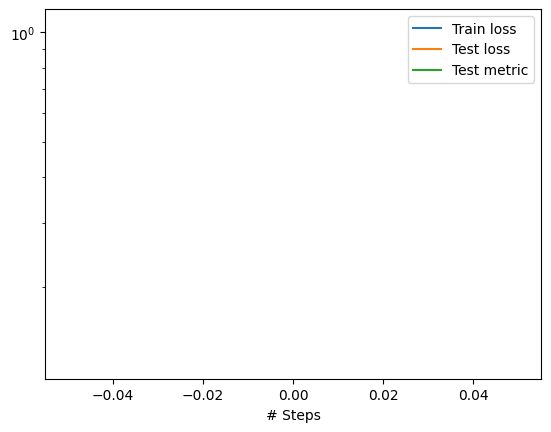

195.05770662133472 34.790780654227284
690
Compiling model...
'compile' took 0.000618 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.50e-01]    [1.25e-01]    [1.04e+00]    

Best model at step 0:
  train loss: 1.50e-01
  test loss: 1.25e-01
  test metric: [1.04e+00]

'train' took 0.093889 s



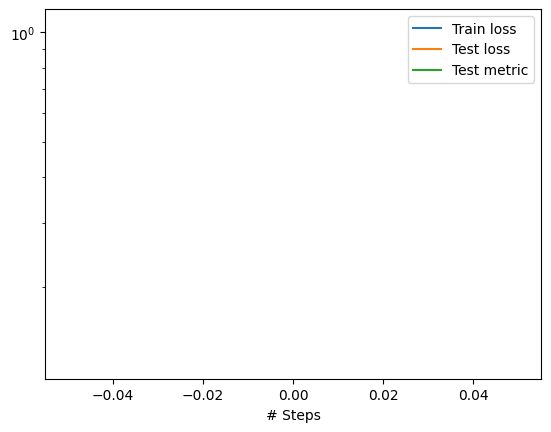

195.24157475780498 34.57318552782687
720
Compiling model...
'compile' took 0.000852 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.62e-01]    [1.25e-01]    [1.04e+00]    

Best model at step 0:
  train loss: 1.62e-01
  test loss: 1.25e-01
  test metric: [1.04e+00]

'train' took 0.083768 s



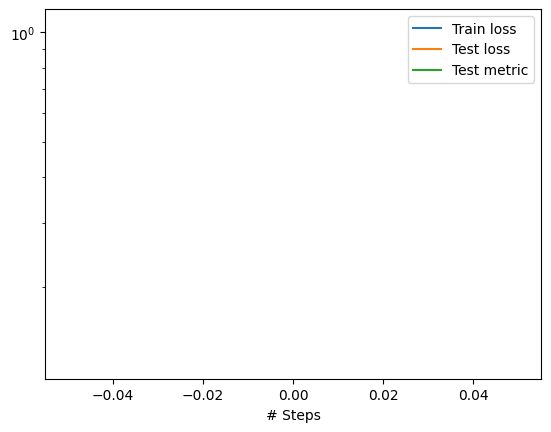

195.2746431270248 34.66831241305613
750
Compiling model...
'compile' took 0.003845 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.59e-01]    [1.25e-01]    [1.04e+00]    

Best model at step 0:
  train loss: 1.59e-01
  test loss: 1.25e-01
  test metric: [1.04e+00]

'train' took 0.090645 s



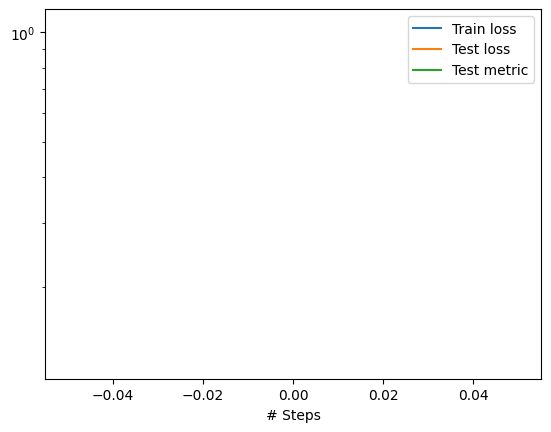

197.37594243220101 35.29448460623921
780
Compiling model...
'compile' took 0.000312 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.55e-01]    [1.25e-01]    [1.04e+00]    

Best model at step 0:
  train loss: 1.55e-01
  test loss: 1.25e-01
  test metric: [1.04e+00]

'train' took 0.104523 s



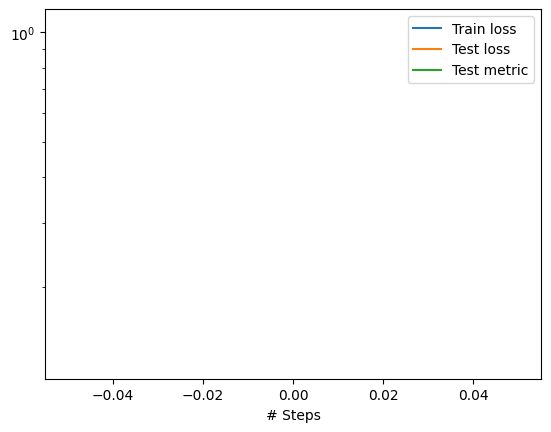

196.3771700964663 34.92289006056899
810
Compiling model...
'compile' took 0.000633 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.44e-01]    [1.25e-01]    [1.04e+00]    

Best model at step 0:
  train loss: 1.44e-01
  test loss: 1.25e-01
  test metric: [1.04e+00]

'train' took 0.089955 s



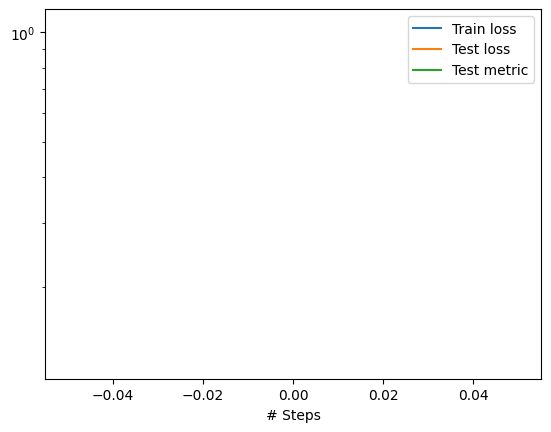

196.04602264398218 35.04054952095011
840
Compiling model...
'compile' took 0.000600 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.50e-01]    [1.25e-01]    [1.04e+00]    

Best model at step 0:
  train loss: 1.50e-01
  test loss: 1.25e-01
  test metric: [1.04e+00]

'train' took 0.100067 s



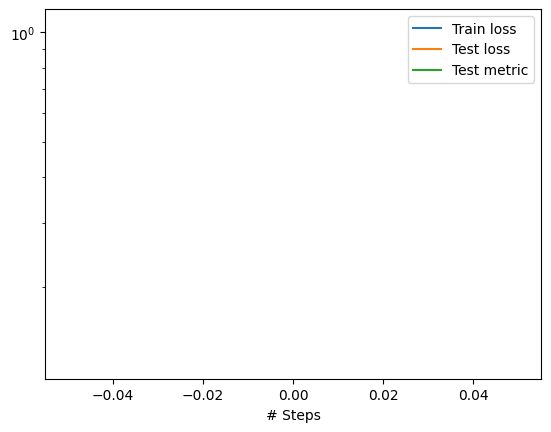

196.06245954928022 35.251924316451095
870
Compiling model...
'compile' took 0.000303 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.52e-01]    [1.25e-01]    [1.04e+00]    

Best model at step 0:
  train loss: 1.52e-01
  test loss: 1.25e-01
  test metric: [1.04e+00]

'train' took 0.106411 s



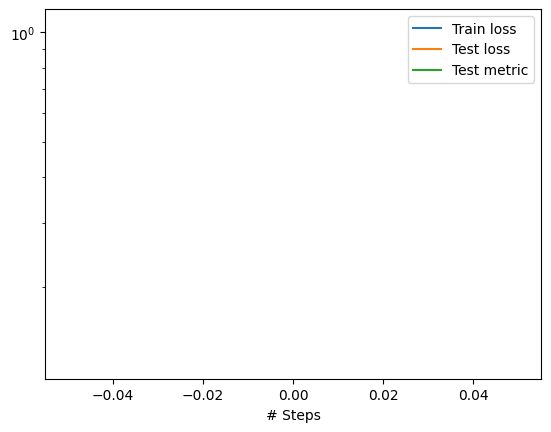

196.23674599485872 35.8651311654096
900
Compiling model...
'compile' took 0.000603 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.56e-01]    [1.25e-01]    [1.04e+00]    
1000      [6.27e-03]    [2.63e-03]    [1.69e-01]    
2000      [1.29e-03]    [6.13e-04]    [8.16e-02]    
3000      [7.57e-04]    [3.75e-04]    [6.40e-02]    
4000      [6.15e-04]    [3.06e-04]    [5.82e-02]    
5000      [2.52e-04]    [1.35e-04]    [3.90e-02]    
6000      [2.45e-04]    [1.38e-04]    [3.90e-02]    
7000      [1.38e-04]    [7.84e-05]    [2.95e-02]    
8000      [3.74e-03]    [1.89e-03]    [1.44e-01]    
9000      [4.27e-04]    [2.59e-04]    [5.44e-02]    
10000     [2.40e-04]    [1.44e-04]    [4.04e-02]    
11000     [1.40e-04]    [8.60e-05]    [3.13e-02]    
12000     [4.30e-04]    [2.12e-04]    [4.72e-02]    
13000     [7.03e-05]    [4.60e-05]    [2.30e-02]    
14000     [5.83e-05]    [3.81e-05]    [2.08e-02]    
15000     [8.13e-05]    [5.11e-05]    [2.37e-02

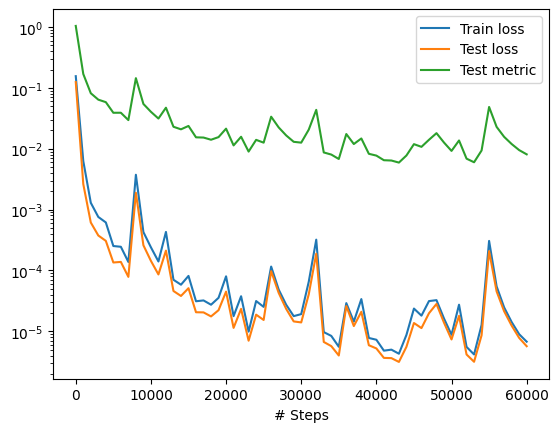

In [52]:

while len(train_vxs) < total_training_vx:
    # generate some vxs to test
    pde_data = dde.data.TimePDE(geomtime, pde, [], num_domain = 20000)
    eval_pts = np.linspace(0, 1, 101)[:, None] # generate 1000 random vxs
    geom = dde.geometry.Interval(0, 1)
    timedomain = dde.geometry.TimeDomain(0, 1)
    geomtime = dde.geometry.GeometryXTime(geom, timedomain)
    func_space = dde.data.GRF(1.0, length_scale = ls, N= 1000, interp="linear")
    testing_new_data = dde.data.PDEOperatorCartesianProd(pde_data, func_space, eval_pts, check_num, [0])
    # testing_model = dde.Model(testing_new_data, net)
    a, _, c = testing_new_data.train_next_batch()
    h1 = H1norm(a[0])
    print(np.mean(h1), np.std(h1))
    topk_index = np.argpartition(h1, -select_num)[-select_num:] # select the top 20 vxs
    topk_vxs = a[0][topk_index]
    uxts = parallel_solver(diffusion_reaction_solver, topk_vxs, num_workers = solver_worker)
    uxts = np.asarray([u for grid, u in uxts]).reshape(-1, 101 * 101)

    # then add the new data to the training set, and train the model
    train_vxs = np.concatenate([train_vxs, topk_vxs], axis = 0)
    train_uxts = np.concatenate([train_uxts, uxts], axis = 0)

    print(len(train_vxs))
    data = PDETripleCartesianProd(X_train=(train_vxs, train_grid), y_train=train_uxts, X_test=(test_vxs, test_grid), y_test=test_uxts, boundary = [])


    model = dde.Model(data, net)
    lr = lr_middle if len(train_vxs) != total_training_vx else lr_end
    decay = decay_middle if len(train_vxs) != total_training_vx else decay_end
    batchsize = batch_middle(len(train_vxs)) if len(train_vxs) != total_training_vx else batch_end(len(train_vxs))
    iterations = iter_middle if len(train_vxs) != total_training_vx else iter_end
    model.compile("adam",
                  lr = lr,
                  metrics = ["mean l2 relative error"],
                  decay = decay,)

    losshistory, train_state = model.train(iterations=iterations, batch_size = batchsize)
    pd_frame = losshistory.to_pandas()
    pd_frame = pd.concat([pd.read_csv(f"results/loss_history_{date}_h1.csv"), pd_frame], axis = 0, ignore_index=True)
    pd_frame.to_csv(f"results/loss_history_{date}_h1.csv", index=False)
    dde.utils.plot_loss_history(losshistory)
    plt.show()

torch.save(model.state_dict(), f"results/model_{date}_h1.pth")